# Kic Kac Memoryless VS MH

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import dblquad

## Implémentation du MH avec Gibss

In [2]:

w=0.5
sigma = 0.1
c=1/10**10
mu= np.array([[3, 5], [7, 5]]).reshape(-1,2)


def log_f(x):
    cum_sum = 0
    for m in mu:
        cum_sum += np.exp(- np.linalg.norm(x - m)/(2 * sigma**2))
    return np.log(w)- np.log(sigma * np.sqrt(2*np.pi)) + np.log(cum_sum)

def densite(x,y):
    return np.exp(log_f((x,y)))

def q(x,y):
    if (x>=2 and x<=8) and (y>=4 and y<=6):
        return 1/12
    else:
        return 0

def accept(prop, x):    
    return np.exp(np.min(np.array([0, log_f(prop) - log_f(x)])))

def MH(z0, accept, N_iter, sigma_prop, s):
    Z = [z0]  
    acc = 0
    for i in range(N_iter):
        z = Z[-1]
        prop = z.copy()
        prop[s] = np.random.normal(z[s], sigma_prop)
        if np.random.uniform(0,1) <= accept(prop, z):
            Z.append(prop)
            acc += 1
        else:
            Z.append(z)
    return Z, acc / N_iter

def Adaptive_Gibbs_sampler(z0, N_iter_outer, N_iter_inner, sigma_prop_init):
    Z = [z0]
    d = z0.shape[0]
    Acceptance = []
    l = np.log(sigma_prop_init)
    b = 0
    j = 0
    order = np.arange(d)
    for i in range(N_iter_outer):
        z = Z[-1]
        if b == 50:
            j += 1
            dj = np.min(np.array([0.01, j**(-0.5)]))
            for s in range(d):
                l[s] = l[s] + dj * (-1)**(acc[s] < 0.24)
            b = 0
        np.random.shuffle(order)
        new_z = z.copy()
        acc = np.empty_like(z)
        for s in order:
            new_Z, acc[s] = MH(new_z, accept, N_iter_inner, np.exp(l[s]), s)
            new_z[s] = new_Z[-1][s]
        Z.append(new_z)
        Acceptance.append(acc)
        b += 1
    return Z, Acceptance

# Implémentation du KKT memoryless


In [3]:
#definir A tel que les points dans A vérifient desnitée(x,y) <= c*q(x,y)
A = []
for x in np.linspace(0,10,100):
    for y in np.linspace(0,10,100):
        if densite(x,y) <= c*q(x,y):
            A.append((x,y))
            
def est_dans_A(x,y):
    if densite(x,y) <= c*q(x,y):
        return True
    else:
        return False


In [4]:
c_2=c*10
def rejection_sampling(n_samples):
    samples = []
    while len(samples) < n_samples:
        x_candidate = np.random.uniform(2, 8)
        y_candidate = np.random.uniform(4, 6)
        while not est_dans_A(x_candidate, y_candidate):
            x_candidate = np.random.uniform(2, 8)
            y_candidate = np.random.uniform(4, 6)
       
        u = np.random.uniform(0, 1)
        
        if u <= densite(x_candidate, y_candidate)/(c_2*q(x_candidate, y_candidate)):
            samples.append([x_candidate, y_candidate])
    
    return np.array(samples)

# Générer des échantillons avec la méthode du rejet
num_samples = 1000
samples = rejection_sampling(num_samples)

In [5]:
# KKT memoryless

def KKT_memoryless(N_iter):
    result=[samples[0]]
    a=1
    for i in range(N_iter):
        #sample sous le kernel du MH 
        prop= np.random.multivariate_normal(result[i], 10*np.eye(2,2))
        if np.random.uniform(0,1) > accept(prop, result[i]):
            prop=result[i]
        # propre au KKT    
        if densite(prop[0],prop[1]) > c*q(prop[0],prop[1]):
            result.append(prop)
        else :
            result.append(samples[a])
            a+=1
    return np.array(result)

    


In [6]:
d = 2
Z, Acceptance = Adaptive_Gibbs_sampler(2*np.ones(d), 1000, 100, 0.5*np.ones(d))
Z = np.array(Z)
KKT=KKT_memoryless(100000)

#countour plot
x = np.linspace(0, 10, 100)
y = np.linspace(0, 10, 100)
X, Y = np.meshgrid(x, y)
ZZ = []
for i in range(100):
    for j in range(100):
        ZZ.append(log_f(np.array([X[i, j], Y[i, j]])))

ZZ = np.array(ZZ).reshape(100,100)


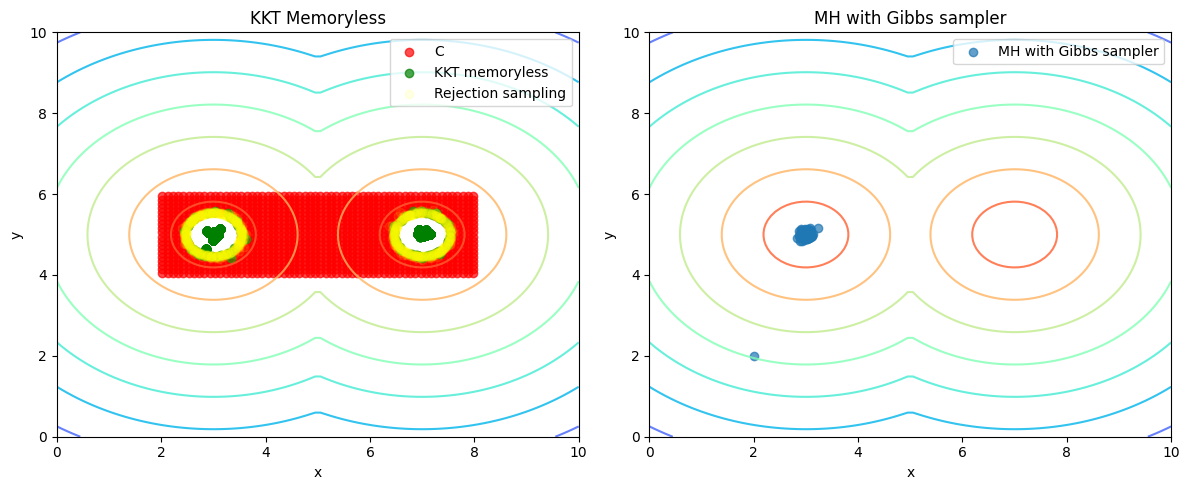

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot on the first subplot
axs[0].scatter(np.array(A)[:,0], np.array(A)[:,1], alpha=0.7, color='red', label='C')
axs[0].scatter(KKT[:,0], KKT[:,1], alpha=0.7, color='green', label='KKT memoryless')
axs[0].scatter(samples[:,0], samples[:,1], alpha=0.1, color='yellow', label='Rejection sampling')
axs[0].contour(X, Y, ZZ, alpha=0.8, cmap='rainbow')
axs[0].set_title( 'KKT Memoryless')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend()

# Plot on the second subplot
axs[1].scatter(Z[:,0], Z[:,1], alpha=0.7, label='MH with Gibbs sampler')
axs[1].contour(X, Y, ZZ, alpha=0.8, cmap='rainbow')
axs[1].set_title('MH with Gibbs sampler')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')
axs[1].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()